# Google Traces Analysis

In [1]:
%matplotlib inline
#import cython
#%load_ext Cython

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os

figsize_base = (6.0, 4.0)
plt.rcParams['figure.figsize'] = (6.0, 4.0)
base_image_path = "figures"

def save_fig(name, extension="pdf", add_param={}):
    plt.savefig(os.path.join(base_image_path, "{}.{}".format(name, extension)), bbox_inches="tight", **add_param)


In [3]:
#tracesPath='/var/tmp/clusterdata-2011-2'
#tracesPath='/mnt/stockage/leo/google-traces/clusterdata-2011-2'
#tasksNums = range(0,10)
tasksNums = range(0,500)

In [7]:
tasksFiles=list(map(lambda x:'task_event/part-'+str(x).zfill(5)+'-of-00500.csv.gz', tasksNums))

In [8]:
print (tasksFiles[0])
print ('to')
print (tasksFiles[-1])

task_event/part-00000-of-00500.csv.gz
to
task_event/part-00499-of-00500.csv.gz


# Read files
and put the data in tasks
tasks : hashtable with 
key (JobID, TaskID)
value : list of [SchedulingClass, Priority, [(event,timestamp) ..]

In [9]:
import gzip
import sys

def read_tasks(tasksFiles):
    tasks={}
    bad_tasks=[]
    arrival=[]
    current_time=0

    for f in tasksFiles:
        print ('File: ', f)
        with gzip.open(f, 'rb') as f:
            for line in f.readlines():
                (timestamp,_,jID,tID,_,evtType,_,schedClass,prio,_,_,_,_)=line.split(',')
                try:
                    if(evtType == '0'):
                        timestamp=int(timestamp)
                        tasks[(int(jID), int(tID))] = (int(schedClass), int(prio), [(0,int(timestamp))])
                        if timestamp>0:
                            arrival.append(timestamp-current_time)
                            current_time=timestamp
                    else:
                        (_,_, events)=tasks[(int(jID),int(tID))]
                        events.append((int(evtType),int(timestamp)))
                except:
                    bad_tasks.append((int(jID), int(tID)))
            print ("Bad", len(bad_tasks))
            print ("Good", len(tasks))
    return arrival,tasks

In [11]:
arrival_time, tasks = read_tasks(tasksFiles)
print ('Finished')

File:  task_event/part-00000-of-00500.csv.gz


FileNotFoundError: [Errno 2] No such file or directory: 'task_event/part-00000-of-00500.csv.gz'

# Content
Look at the number of event per task, and of events that are incomplete and of the ending type of events finishsing

In [8]:
def tasks_stats(tasks):
    l=defaultdict(int)
    bad=0
    last_event=defaultdict(int)
    for i in tasks:
        evts=tasks[i][2]
        li=len(evts)
        l[li]=l[li]+1
        if li==3:
            if evts[0][0] != 0 or evts[1][0]!= 1:
                bad=bad+1
            last_event[evts[2][0]]=last_event[evts[2][0]]+1
    return (dict(l),dict(last_event), bad)

l, last, bad = tasks_stats(tasks)
print 'Number of events', l, 'Total :', len(tasks)
print 'Number of bad events', bad
print 'Final events for three events', last


Number of events {1: 248, 2: 1093992, 3: 24258907, 4: 19378, 5: 17215, 6: 8510, 7: 5093, 8: 3028, 9: 4024, 10: 1364, 11: 1099, 12: 898, 13: 1375, 14: 550, 15: 1093, 16: 1417, 17: 755, 18: 1570, 19: 492, 20: 635, 21: 274, 22: 141, 23: 358, 24: 118, 25: 127, 26: 76, 27: 30, 28: 8, 29: 7, 30: 13, 32: 2, 33: 1182, 34: 11, 35: 2, 36: 34, 37: 34, 38: 67, 39: 77, 40: 169, 41: 116, 42: 108, 43: 96, 44: 23, 45: 13, 46: 1, 53: 1} Total : 25424731
Number of bad events 179
Final events for three events {1: 2, 2: 8626, 3: 86348, 4: 17775284, 5: 6381906, 6: 5102, 8: 1639}


## Table 1 : Distribution of number of events per task

In [9]:
neuf=0
for key, value in l.items():
    if key>8:
        neuf+=value
for key,value in l.items():
    if (key<9):
        print key,":",value
print '+ 9 :',neuf

1 : 248
2 : 1093992
3 : 24258907
4 : 19378
5 : 17215
6 : 8510
7 : 5093
8 : 3028
+ 9 : 18360


## Table II : Distribution of finishing event for all tasks with three events

In [10]:
d_events_type={}
d_events_type["finish"]=0
d_events_type["kill"]=0
d_events_type["fail"]=0
d_events_type["other"]=0
d_events_type["total"]=0

for key,value in last.items():
    if (key==1):
        d_events_type["other"]+=value
    if (key==2):
        d_events_type["other"]+=value
    if (key==3):
        d_events_type["fail"]+=value
    if (key==4):
        d_events_type["finish"]+=value
    if (key==5):
        d_events_type["kill"]+=value
    if (key==6):
        d_events_type["other"]+=value
    if (key==8):
        d_events_type["other"]+=value
    d_events_type["total"]+=value
print 'NUMBER'
print d_events_type
total = d_events_type["total"]
print 'PERCENTAGE'
for key,value in d_events_type.items():
    res = float(value*100)
    res= float(res/total)
    print key,res

NUMBER
{'fail': 86348, 'total': 24258907, 'finish': 17775284, 'kill': 6381906, 'other': 15369}
PERCENTAGE
fail 0.355943489128
total 100.0
finish 73.2732270254
kill 26.3074754357
other 0.0633540497105


In [11]:
print 'Dans le cas des 500 fichiers :'
print 'Number of events {1: 248, 2: 1093992, 3: 24258907, 4: 19378, 5: 17215, 6: 8510, 7: 5093, 8: 3028, 9: 4024, 10: 1364, 11: 1099, 12: 898, 13: 1375, 14: 550, 15: 1093, 16: 1417, 17: 755, 18: 1570, 19: 492, 20: 635, 21: 274, 22: 141, 23: 358, 24: 118, 25: 127, 26: 76, 27: 30, 28: 8, 29: 7, 30: 13, 32: 2, 33: 1182, 34: 11, 35: 2, 36: 34, 37: 34, 38: 67, 39: 77, 40: 169, 41: 116, 42: 108, 43: 96, 44: 23, 45: 13, 46: 1, 53: 1} Total : 25424731'
print 'Number of bad events 179'
print 'Final events for three events {1: 2, 2: 8626, 3: 86348, 4: 17775284, 5: 6381906, 6: 5102, 8: 1639}'

Dans le cas des 500 fichiers :
Number of events {1: 248, 2: 1093992, 3: 24258907, 4: 19378, 5: 17215, 6: 8510, 7: 5093, 8: 3028, 9: 4024, 10: 1364, 11: 1099, 12: 898, 13: 1375, 14: 550, 15: 1093, 16: 1417, 17: 755, 18: 1570, 19: 492, 20: 635, 21: 274, 22: 141, 23: 358, 24: 118, 25: 127, 26: 76, 27: 30, 28: 8, 29: 7, 30: 13, 32: 2, 33: 1182, 34: 11, 35: 2, 36: 34, 37: 34, 38: 67, 39: 77, 40: 169, 41: 116, 42: 108, 43: 96, 44: 23, 45: 13, 46: 1, 53: 1} Total : 25424731
Number of bad events 179
Final events for three events {1: 2, 2: 8626, 3: 86348, 4: 17775284, 5: 6381906, 6: 5102, 8: 1639}


# Wating time
Waiting time
- First graph is absolute waiting time in seconds
- Second graph is relative waiting time to the lenght of the task

In [12]:
def analyse_tasks(tasks):
    waiting_time={'Good':[], 'Bad':[]}
    relative_waiting_time={'Good':[], 'Bad':[]}
    makespan={'Good':[], 'Bad':[]}
    classification = {'Good':[], 'Bad':[]}
    submass_={'Good':defaultdict(int), 'Bad':defaultdict(int)}
    realmass_={'Good':defaultdict(int), 'Bad':defaultdict(int)}

    for t in tasks:
        sclass, prio, evts=tasks[t]
        if len(evts)>=3 and (evts[-1][0] == 4 or evts[-1][0] == 5):
            subtime=evts[0][1]
            runtime=evts[1][1]
            endtime=evts[2][1]
            diff=runtime-subtime
            diffrel=diff/float(endtime-runtime)
            mt=float(endtime-runtime)/1000000.0
            tmp = (sclass, prio, float(diff)/1000000, diffrel, mt)
            status='Good'
            if evts[-1][0]== 5 :
                status='Bad'
            waiting_time[status].append(float(diff)/1000000.0)
            relative_waiting_time[status].append(diffrel)
            makespan[status].append(mt)
            classification[status].append(tmp)
            submass_[status][subtime] += 1
            submass_[status][subtime+endtime-runtime] -=1

            realmass_[status][runtime] += 1
            realmass_[status][endtime] -= 1
    return waiting_time, relative_waiting_time, makespan, classification, submass_, realmass_

waiting_time, relative_waiting_time, makespan, classification, submass_, realmass_=analyse_tasks(tasks)
tasks=[]
print 'Les taches qui finissent bien', len(makespan['Good']), 'Total :', sum(makespan['Good']), 'Mean', sum(makespan['Good'])/float(len(makespan['Good']))
print 'Les taches qui finissent mal ', len(makespan['Bad']), 'Total :', sum(makespan['Bad']), 'Mean', sum(makespan['Bad'])/float(len(makespan['Bad']))


Les taches qui finissent bien 17807965 Total : 30159205857.8 Mean 1693.57957845
Les taches qui finissent mal  6419660 Total : 51320980647.2 Mean 7994.34559575


# Test : log normal distribution - pareto 

In [13]:
import scipy.stats

for t in ['Good', 'Bad']:
    print("## Makespan stats for {} tasks".format(t))

    for dist_name in ['lognorm', 'pareto']:
        d = getattr(scipy.stats, dist_name)

        param = d.fit(makespan[t], floc=0)
        print("Fit params for {} : {}".format(dist_name, param))
        cdf =  lambda x: d.cdf(x, *param[:-2], loc=param[-2], scale=param[-1])

        ks = scipy.stats.kstest(makespan[t], cdf)
        print("KS test for {} : {}".format(dist_name, ks))

## Makespan stats for Good tasks
Fit params for lognorm : (1.4212266630988188, 0, 517.69627936618781)
KS test for lognorm : (0.056843361118668223, 0.0)


/usr/lib/python2.7/dist-packages/scipy/stats/distributions.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fit params for pareto : (0.11286526232991492, 0, 0.073068999993754338)
KS test for pareto : (0.50199217569709587, 0.0)
## Makespan stats for Bad tasks
Fit params for lognorm : (2.0564740975503595, 0, 463.99375773325403)
KS test for lognorm : (0.064233134133444392, 0.0)
Fit params for pareto : (0.091550438630806197, 0, 0.0077039999987571512)
KS test for pareto : (0.48754334039537983, 0.0)


# Stats

In [14]:
print 'sc, prio, diff, diffrel, makespan'
print classification['Good'][:10]

sc, prio, diff, diffrel, makespan
[(1, 2, 2.469383, 0.0001874781410543501, 13171.578223), (0, 4, 1.290144, 0.0027936464810472826, 461.813622), (0, 0, 2.396646, 0.022818108131992577, 105.032634), (0, 4, 4.663145, 0.006099350035643138, 764.531462), (0, 0, 1.336107, 0.005289367294432614, 252.602424), (0, 4, 1.503338, 0.0023671063103712876, 635.095261), (0, 4, 31.370127, 0.006090222596532824, 5150.899906), (0, 4, 2.001668, 0.010291355836007984, 194.499931), (0, 6, 4.926309, 0.030516940718056485, 161.428665), (1, 4, 1.13914, 0.0018454203207303387, 617.279428)]


# classes & prio

In [15]:
def qual(data):
    scl=[0]*4
    priol=[0]*13
    for (sc, prio, diff, diffrel, makespan) in data:
        scl[int(sc)] += 1
        priol[int(prio)] += 1
    return scl, priol

(sclGood, prioGood) = qual(classification['Good'])
print 'Good'
print 'Schedulin Classes' , sclGood
print 'Priorities', prioGood

(sclBad, prioBad) = qual(classification['Bad'])
print 'Bad'
print 'Schedulin Classes' , sclBad
print 'Priorities', prioBad

scl={'Good':sclGood,'Bad':sclBad}
prio={'Good':prioGood,'Bad':prioBad}

Good
Schedulin Classes [14901940, 2738022, 167943, 60]
Priorities [3439929, 1641846, 986540, 982, 11076548, 104, 498723, 0, 114103, 49190, 0, 0, 0]
Bad
Schedulin Classes [5415458, 589261, 365387, 49554]
Priorities [2261617, 715428, 91936, 45, 2898530, 0, 134722, 0, 135829, 180974, 579, 0, 0]


## Relation between priority and scheduling class

In [16]:
prio_sclasses = {}
priogroup_sclasses = {}

def classify_prio_sclasses(name, classif):
    sclasses_grouped = []
    prio_groups = [range(0, 2), range(2, 9), [9, 11], [10]]
    sclasses_prio = [ 12*[0] for x in range(4) ]
    
    for t in classif:
        sclasses_prio[t[0]][t[1]] += 1
        
    # normalization
    sclasses_count = 4*[0]
    for i in range(4):
        count = sum(sclasses_prio[i])
        sclasses_count[i] = count
        #print("sclass {} : {} tasks".format(i, count))
        if count != 0:
            sclasses_prio[i] = [ sclasses_prio[i][j] / float(count) for j in range(12)]
    
    # priority groups
    for i in range(4):
        sclass = []
        for group in prio_groups:
            groupsum = 0.0
            for j in group:
                groupsum += sclasses_prio[i][j]
            sclass.append(groupsum)
        sclasses_grouped.append(sclass)

    global prio_sclasses
    global priogroup_sclasses
    prio_sclasses[name] = sclasses_prio
    priogroup_sclasses[name] = sclasses_grouped
    

In [17]:
classify_prio_sclasses('Good', classification['Good'])
classify_prio_sclasses('Bad', classification['Bad'])
classify_prio_sclasses('All', classification['Bad'] + classification['Good'])

sclasses_colors = ['green', 'greenyellow', 'orange', 'red']

### For 'good' tasks

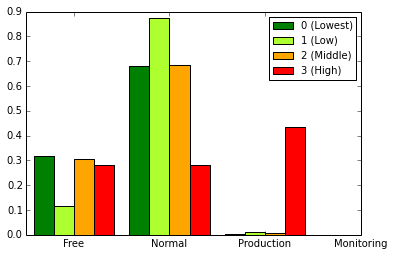

In [18]:
fig, ax = plt.subplots()
#fig.set_size_inches(10.0, 5.0)
#plt.title('Distribution of priority groups for each scheduling class for finishing tasks')

ind = np.arange(4)
width = 0.21
rects = []
for i in range(4):
    rects.append(ax.bar(ind + (i-2)*width, priogroup_sclasses['Good'][i], width=width, color=sclasses_colors[i]))

ax.set_xticks(ind)
ax.set_xticklabels(['Free', 'Normal', 'Production', 'Monitoring'])
ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'),fontsize='medium')
save_fig("distrib_sclass_prio_finish")

### For 'bad' tasks (services)

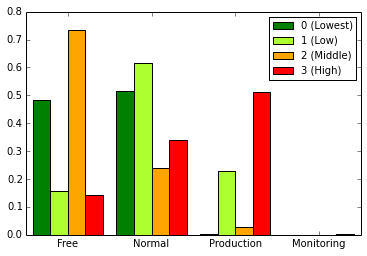

In [19]:
fig, ax = plt.subplots()


ind = np.arange(4)
width = 0.21
rects = []
for i in range(4):
    rects.append(ax.bar(ind + (i-2)*width, priogroup_sclasses['Bad'][i], width=width, color=sclasses_colors[i]))

ax.set_xticks(ind)
ax.set_xticklabels(['Free', 'Normal', 'Production', 'Monitoring'])
#ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'), loc="right")
ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'), fontsize='medium')

save_fig("distrib_sclass_prio_killed")

### For all tasks

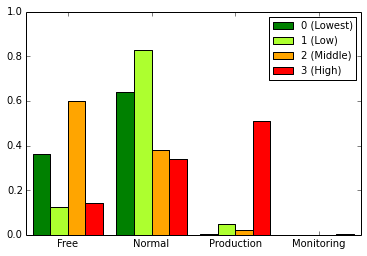

In [20]:
fig, ax = plt.subplots()
#fig.set_size_inches(10.0, 5.0)
#plt.title('Distribution of task priority among each scheduling class')

ind = np.arange(4)
width = 0.21
rects = []
for i in range(4):
    rects.append(ax.bar(ind + (i-2)*width, priogroup_sclasses['All'][i], width=width, color=sclasses_colors[i]))

ax.set_ybound(0, 1)
ax.set_xticks(ind)
ax.set_xticklabels(['Free', 'Normal', 'Production', 'Monitoring'])
ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'),fontsize='medium')
save_fig("distrib_sclass_prio")

## Makespan stats for tasks and services

In [21]:
def priogroup_makespan_stats(classif):
    # 12 priority levels
    prio_makespan = [[] for _ in range(12)]

    for t in classif:
        prio_makespan[t[1]].append(t[4])

    # stats
    prio_makespan_average = [np.average(m) for m in prio_makespan]
    prio_makespan_std = [np.std(m) for m in prio_makespan]
    prio_makespan_median = [np.median(m) for m in prio_makespan]

    # stats for priority groups
    pm = prio_makespan
    gprio_makespan = [pm[0] + pm[1], pm[2] + pm[3] + pm[4] + pm[5] + pm[6] + pm[7] + pm[8], pm[9] + pm[11], pm[10]]

    gprio_makespan_average = [np.average(m) for m in gprio_makespan]
    gprio_makespan_std = [np.std(m) for m in gprio_makespan]
    gprio_makespan_median = [np.median(m) for m in gprio_makespan]

    # stats for ALL tasks
    am = []
    for m in pm:
        am += m
    all_stats = [len(am), np.average(am), np.std(am), np.median(am)]
    #print("All : {}".format(all_stats))

    #print("Task number for each priority group : {}".format([len(m) for m in gprio_makespan]))
    #print("Task makespan mean for each priority group : {}".format(gprio_makespan_average))
    #print("Task makespan median for each priority group : {}".format(gprio_makespan_median))
    #print("Task makespan std dev for each priority group : {}".format(gprio_makespan_std))
    
    ret = {}
    for pgroup in [('Free', 0), ('Normal', 1), ('Production', 2), ('Monitoring', 3), ('All', -1)]:
        tmp = {}
        if pgroup[1] >= 0:
            tmp['count'] = len(gprio_makespan[pgroup[1]])
            tmp['avg'] = gprio_makespan_average[pgroup[1]]
            tmp['std'] = gprio_makespan_std[pgroup[1]]
            tmp['med'] = gprio_makespan_median[pgroup[1]]
        else:
            # all
            tmp['count'] = all_stats[0]
            tmp['avg'] = all_stats[1]
            tmp['std'] = all_stats[2]
            tmp['med'] = all_stats[3]
        ret[pgroup[0]] = tmp
        
    return ret





In [22]:
priogroup_makespan = {}
priogroup_makespan['Good'] = priogroup_makespan_stats(classification['Good'])
priogroup_makespan['Bad'] = priogroup_makespan_stats(classification['Bad'])

print("All statistics for both Tasks and Services (table VI and VII) :")
print(str(priogroup_makespan))

/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:91: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:113: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


All statistics for both Tasks and Services (table VI and VII) :
{'Bad': {'All': {'count': 6419660, 'std': 59363.797782965485, 'avg': 7994.3455957533452, 'med': 333.82506899999998}, 'Production': {'count': 180974, 'std': 294182.35499764903, 'avg': 148424.38833104685, 'med': 31429.425025500001}, 'Monitoring': {'count': 579, 'std': 579101.91805430409, 'avg': 388232.54421172565, 'med': 71831.589154999994}, 'Free': {'count': 2977045, 'std': 24336.442485204927, 'avg': 5195.6308373594229, 'med': 595.42672900000002}, 'Normal': {'count': 3261062, 'std': 19468.978667944168, 'avg': 2688.5756677143754, 'med': 213.9071375}}, 'Good': {'All': {'count': 17807965, 'std': 5034.5250872828892, 'avg': 1693.5795784507297, 'med': 448.90721300000001}, 'Production': {'count': 49190, 'std': 1955.1163226978615, 'avg': 493.89708989109852, 'med': 39.124604500000004}, 'Monitoring': {'count': 0, 'std': nan, 'avg': nan, 'med': nan}, 'Free': {'count': 5081775, 'std': 4518.6755414386571, 'avg': 1937.9013453466578, 'med

In [23]:
# Prepare only the average for next figure (reversed classification)
average_all_gprio = {}

for etype in ['Good', 'Bad']:
    tmp = []
    for g in ['Free', 'Normal', 'Production', 'Monitoring']:
        tmp.append(priogroup_makespan[etype][g]['avg'])
    average_all_gprio[etype] = tmp

/usr/lib/pymodules/python2.7/matplotlib/scale.py:97: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


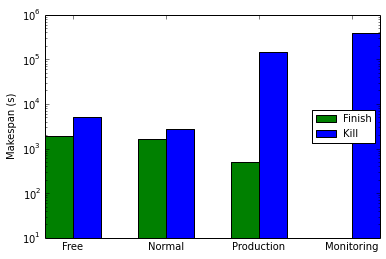

In [24]:
fig, ax = plt.subplots()
#plt.title('Average makespan for each priority')
ax.set_yscale('log', nonposy='clip')
ax.set_ylabel('Makespan (s)')
plt.xticks(range(4), ['Free', 'Normal', 'Production', 'Monitoring'])

#plt.bar(np.arange(4)-0.3, gprio_makespan_average, yerr=gprio_makespan_std, color='y', width=0.6)
ax.bar(np.arange(4)-0.3, average_all_gprio['Good'], color='g', width=0.3, label='Finish')
ax.bar(np.arange(4), average_all_gprio['Bad'], color='b', width=0.3, label='Kill')

ax.set_ybound(10)
plt.legend(loc="right", fontsize='medium')
save_fig("makespan_average_finish_kill")

# Histograms of makespan for both Good/Bad


In [25]:
makespans = {}

for etype in ['Good', 'Bad']:
    temp = []
    for t in classification[etype]:
        temp.append(t[4])
    makespans[etype] = temp
    print(len(temp))

17807965
6419660


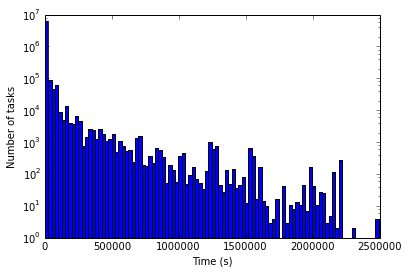

In [26]:
plt.figure()

#plt.title('Distribution of makespan for killed tasks')
plt.yscale('log', nonposy='clip')
plt.hist(makespans['Bad'],100)
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
save_fig("makespan_histo_kill")

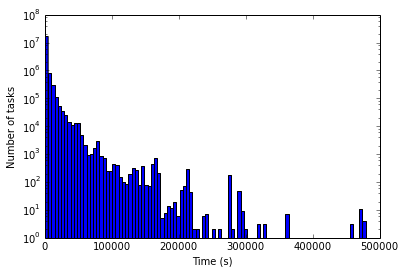

In [27]:
plt.figure()

#plt.title('Distribution of makespan for finished tasks')
plt.yscale('log', nonposy='clip')
plt.hist(makespans['Good'],100)
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
save_fig("makespan_histo_finish")

# Arrival time

Interarrival time : mean=0.05196260895,median=2e-06
[600.047726, 0.771533, 2.489368, 0.737554, 9.9e-05, 0.0002, 1.2e-05, 8.7e-05, 1.540691, 0.000363]
finished


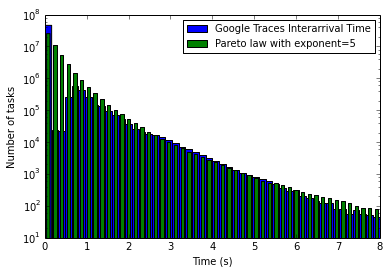

In [37]:
arrival_delta = map(lambda x: float(x)/1000000, arrival_time)
print arrival_delta[:10] 
print("Interarrival time : mean={},median={}".format(np.mean(arrival_delta), np.median(arrival_delta)))


import numpy as np
from scipy.stats import kstest
import scipy as sc

#print kstest(arrival_delta, 'expon')

#(b,loc, scale) = sc.stats.pareto.fit(arrival_delta, .7)
print 'finished'
images_path ="figures_res/"

#fig, ax = plt.subplots(1, 1)
#print (b,loc, scale)

fig, ax = plt.subplots()
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
plt.yscale('log', nonposy='clip')
vals = sc.stats.pareto.rvs(5,  size=len(arrival_time))

v1=[x for x in arrival_delta if x < 8]
v2=[x-1 for x in vals if x < 9]

#_=plt.hist([v1,v2],100)

ax.hist(v1, 50)
ax.hist(v2, 50, rwidth=.5)
#title='Distribution of inter-arrival time'
ax.legend(['Google Traces Interarrival Time','Pareto law with exponent=5'],fontsize='medium')
save_fig('interarrival')
#plt.title('Distribution of inter-arrival time')


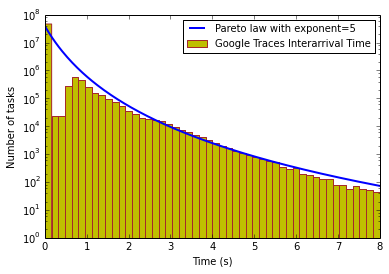

In [29]:

fig, ax = plt.subplots()
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
plt.yscale('log', nonposy='clip')
vals = sc.stats.pareto.rvs(5,  size=len(arrival_time))

v1=[x for x in arrival_delta if x < 8]
v2=[x-1 for x in vals if x < 9]

nbbins = 50.0
xlim = 8.0

x = np.linspace(0.01, 8, 200)
factor = len(v1) * (xlim/nbbins)
pareto_model = sc.stats.pareto.pdf(x, 5, loc=-1) * factor

#_=plt.hist([v1,v2],100)

ax.hist(v1, 50, color='y', edgecolor='brown', label='Google Traces Interarrival Time')
ax.plot(x, pareto_model, color='b', label='Pareto law with exponent=5', linewidth=2)

ax.set_ybound(lower=1)

#ax.hist(v2, 50, rwidth=.5)
#title='Distribution of inter-arrival time'
ax.legend(fontsize='medium')
save_fig('interarrival_plot')
#plt.title('Distribution of inter-arrival time')


# Tables



In [30]:
def tasks_stats(tasks):
    l=defaultdict(int)
    bad=0
    last_event=defaultdict(int)
    for i in tasks:
        evts=tasks[i][2]
        li=len(evts)
        l[li]=l[li]+1
        if li==3:
            if evts[0][0] != 0 or evts[1][0]!= 1:
                bad=bad+1
            last_event[evts[2][0]]=last_event[evts[2][0]]+1
    return (dict(l),dict(last_event), bad)

l, last, bad = tasks_stats(tasks)
print 'Number of events', l, 'Total :', len(tasks)
print 'Number of bad events', bad
print 'Final events for three events', last

Number of events {} Total : 0
Number of bad events 0
Final events for three events {}


## Table III : Number of tasks and frequency for each scheduling class

In [31]:
sclTotal = []
for i in range(len(sclGood)):
    sclTotal.append(sclGood[i] + sclBad[i]) 
    
sclTotalPercentage = [float(x) * 100.0 / sum(sclTotal) for x in sclTotal]

print(sclTotal)
print(sclTotalPercentage)

[20317398, 3327283, 533330, 49614]
[83.86046094076494, 13.733426202527074, 2.201330093230352, 0.20478276347764174]


## Table IV : Number of tasks for each priority level

In [32]:
prioTotal = []
for i in range(len(prioGood)):
    prioTotal.append(prioGood[i] + prioBad[i]) 

print(prioTotal)

[5701546, 2357274, 1078476, 1027, 13975078, 104, 633445, 0, 249932, 230164, 579, 0, 0]


## Table V : Number of tasks and frequency for the four priority groups

In [33]:
prio_groups = [range(0, 2), range(2, 9), [9, 11], [10]]
    
# priority groups
prioGroupsTotal = []
for group in prio_groups:
    groupsum = 0
    for j in group:
        groupsum += prioGood[j] + prioBad[j]
    prioGroupsTotal.append(groupsum)

prioGroupsPercentage = [float(x) * 100.0 / sum(prioGroupsTotal) for x in prioGroupsTotal]
    
print(prioGroupsTotal)
print(prioGroupsPercentage)

[8058820, 15938062, 230164, 579]
[33.26293848447795, 65.78466523235356, 0.9500064492495653, 0.002389833918925194]


## Table VI : Statistics for execution time of task finsihed by a Finish event 

In [34]:
# 12 priority levels
prio_makespan = [[] for _ in range(12)]

for t in classification['Good']:
    prio_makespan[t[1]].append(t[4])

# stats
prio_makespan_average = [np.average(m) for m in prio_makespan]
prio_makespan_std = [np.std(m) for m in prio_makespan]
prio_makespan_median = [np.median(m) for m in prio_makespan]

pm = prio_makespan
gprio_makespan = [pm[0] + pm[1], pm[2] + pm[3] + pm[4] + pm[5] + pm[6] + pm[7] + pm[8], pm[9] + pm[11], pm[10]]

gprio_makespan_average = [np.average(m) for m in gprio_makespan]
gprio_makespan_std = [np.std(m) for m in gprio_makespan]
gprio_makespan_median = [np.median(m) for m in gprio_makespan]


am = []
for m in pm:
    am += m
all_stats = [len(am), np.average(am), np.std(am), np.median(am)]
print("All : {}".format(all_stats))

print("Task number for each priority group : {}".format([len(m) for m in gprio_makespan]))
print("Task makespan mean for each priority group : {}".format(gprio_makespan_average))
print("Task makespan median for each priority group : {}".format(gprio_makespan_median))
print("Task makespan std dev for each priority group : {}".format(gprio_makespan_std))


All : [17807965, 1693.5795784507297, 5034.5250872828892, 448.90721300000001]
Task number for each priority group : [5081775, 12677000, 49190, 0]
Task makespan mean for each priority group : [1937.9013453466578, 1600.2944269675959, 493.89708989109852, nan]
Task makespan median for each priority group : [345.790075, 492.56216949999998, 39.124604500000004, nan]
Task makespan std dev for each priority group : [4518.6755414386571, 5231.3686295941561, 1955.1163226978615, nan]


## Table VII : Statistics for execution time of tasks finished by a Kill event

In [35]:
# 12 priority levels
prio_makespan = [[] for _ in range(12)]

for t in classification['Bad']:
    prio_makespan[t[1]].append(t[4])

# stats
prio_makespan_average = [np.average(m) for m in prio_makespan]
prio_makespan_std = [np.std(m) for m in prio_makespan]
prio_makespan_median = [np.median(m) for m in prio_makespan]

pm = prio_makespan
gprio_makespan = [pm[0] + pm[1], pm[2] + pm[3] + pm[4] + pm[5] + pm[6] + pm[7] + pm[8], pm[9] + pm[11], pm[10]]

gprio_makespan_average = [np.average(m) for m in gprio_makespan]
gprio_makespan_std = [np.std(m) for m in gprio_makespan]
gprio_makespan_median = [np.median(m) for m in gprio_makespan]


am = []
for m in pm:
    am += m
all_stats = [len(am), np.average(am), np.std(am), np.median(am)]
print("All : {}".format(all_stats))


print("Task number for each priority group : {}".format([len(m) for m in gprio_makespan]))
print("Task makespan mean for each priority group : {}".format(gprio_makespan_average))
print("Task makespan median for each priority group : {}".format(gprio_makespan_median))
print("Task makespan std dev for each priority group : {}".format(gprio_makespan_std))
print("test max : {}".format([max(m if len(m) != 0 else [0]) for m in gprio_makespan]))


All : [6419660, 7994.3455957533452, 59363.797782965485, 333.82506899999998]
Task number for each priority group : [2977045, 3261062, 180974, 579]
Task makespan mean for each priority group : [5195.6308373594229, 2688.5756677143754, 148424.38833104685, 388232.54421172565]
Task makespan median for each priority group : [595.42672900000002, 213.9071375, 31429.425025500001, 71831.589154999994]
Task makespan std dev for each priority group : [24336.442485204927, 19468.978667944168, 294182.35499764903, 579101.91805430409]
test max : [1895984.935249, 2075736.979765, 2491521.08298, 2222525.79188]


# K-means analysis
Clustering of tasks on makespan, prio, sclass.
Using sklearn for several reasons (better tools, results and efficiency).

In [ ]:
from numpy import array
from scipy.cluster.vq import vq, kmeans, kmeans2, whiten
import random


from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:

# prepare data
all_no_diff = lambda sclass, prio, diff, diffrel, makespan : (float(makespan), prio, sclass)
#all_no_diff_filter = lambda sclass, prio, diff, diffrel, makespan : diff<100000 and diff > 0.01 and makespan < 10000000 and makespan > 1
all_no_diff_filter = lambda sclass, prio, diff, diffrel, makespan : makespan > 1


def prepare_data_kmeans(fields_func, filter_func):
    transform = lambda items : array([fields_func(*item) for item in items if filter_func(*item)])
    
    items_good = transform(classification['Good'])
    items_bad = transform(classification['Bad'])
    
    items_all = np.concatenate((items_good, items_bad))
    
    std_items = np.std(items_all, 0)
    
    return (np.divide(items_all, std_items), len(items_good), std_items)
    

def do_kmeans_analysis2(k, whiten, good_nb, std_items, postprocess_func=None):
    nbcluster = k
    
    #centroids_whiten, distortion = kmeans(whiten, nbcluster)
    #idx,_ = vq(whiten, centroids_whiten)

    resolv = KMeans(k)
    resolv.fit(whiten)
    idx = resolv.predict(whiten)
    centroids_whiten = resolv.cluster_centers_
    distortion = resolv.score(whiten)
    
    
    # XXX : we suppose the full whiten array is a concatenation of [good, bad] arrays
    goodones = idx[:good_nb]
    badones = idx[good_nb:]
    
    centroids = np.multiply(centroids_whiten, std_items)
    
    print('For {}-means, distortion = {}'.format(k, distortion))
    for c in centroids:
        print('\t centroid : {}'.format(c))
        
    # distribution between the two groups
    print('Rate between Finished ane Killed tasks for the different clusters')
    for i in range(k):
        rate = lambda i, x: (x == i).sum() / float(len(x)) * 100.0
        print('Group {0}  : ({1:.3f}%, {2:.3f}%)'.format(i, rate(i, goodones), rate(i, badones)))


    format_centroid = lambda c: '[makespan {0:.2f}, prio {1:.3f}, sclass {2:.3f}]'.format(*c)
    for i in range(k):
        nb = (idx == i).sum()
        print('Centroid {0}, nb = {1}'.format(format_centroid(centroids[i]), nb))

    if postprocess_func is not None:
        postprocess_func(k, whiten, std_items, resolv)
    
    # TODO here
    return (k, whiten, std_items, resolv)

In [ ]:
# almost a copy-past from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def show_silouhette(k, whiten, std_items, resolv, plot_samples=5000, xlim=[-0.05, 1]):
    X = whiten
    n_clusters = k
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    #fig.set_size_inches(18, 7)
    
    plot_samples = len(X) if plot_samples is None else plot_samples

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim(xlim)
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, plot_samples + (n_clusters + 1) * 10])

    clusterer = resolv
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    
    sample =  np.random.choice(X.shape[0], plot_samples, replace=False)
    print(str(X.shape))
    print(str(sample.shape))
    X_resamp = X[sample]
    cluster_labels = cluster_labels[sample]
    
    silhouette_avg = silhouette_score(X_resamp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_resamp, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
            
        #print(str(ith_cluster_silhouette_values.shape))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("Silhouette plot for the 4-cluster")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.show()

In [ ]:
def analysis_makespan_clusters(k, whiten, std_items, clusterer):
    data = np.multiply(whiten, std_items) 

    idx = clusterer.fit_predict(whiten)
    
    for i in range(k):
        cluster_data = data[idx == i]
        cluster_makespan = cluster_data[:,0]
        
        avg = np.average(cluster_makespan)
        std = np.std(cluster_makespan)
        median = np.median(cluster_makespan)
        
        print('Cluster {0}: avg={1:.3f}, std={2:.3f}, med={3:.3f}'.format(i, avg, std, median))

## Analysis score of different values of k

In [ ]:
def kmeans_distortion2(items, nbcluster, nrun = 1):
    all_disp = []
    for i in range(nrun):
        resolv = KMeans(nbcluster)
        resolv.fit(items)
        disp = -resolv.score(items) / len(items)
        #_, disp = kmeans(items, nbcluster)
        all_disp.append(disp)
    return np.mean(disp)

In [ ]:
disp_kmeans = []
(whiten_items, _, _) = prepare_data_kmeans(all_no_diff, all_no_diff_filter)

for k in range(1, 12):
    disp = kmeans_distortion2(whiten_items, k, 1)
    disp_kmeans.append( (k, disp) )
    print(str( (k, disp) ))

In [ ]:
fig, ax = plt.subplots()
plt.ylabel('Average distance')
plt.xlabel('Number of cluster (k)')

# TODO : diff entre k et k+1 (% ou value)
# --> justif du choix de k dans le texte

plt.plot(*zip(*disp_kmeans), marker='x')
save_fig('distance_cluster')

In [ ]:
delta_dist = [(k, a-b) for (_, a), (k, b) in zip(disp_kmeans, disp_kmeans[1:])]
delta_dist

## For 2-clustering

In [ ]:
prepared_data = prepare_data_kmeans(all_no_diff, all_no_diff_filter)
kmean_partial = do_kmeans_analysis2(2, *prepared_data)

In [ ]:
show_silouhette(*kmean_partial, plot_samples=20000, xlim=[-0.1, 1])
save_fig('silhouette_2_clustering')

In [ ]:
analysis_makespan_clusters(*kmean_partial)

## For 4-clustering

In [ ]:
prepared_data = prepare_data_kmeans(all_no_diff, all_no_diff_filter)
kmean_partial = do_kmeans_analysis2(4, *prepared_data)

In [ ]:
show_silouhette(*kmean_partial, plot_samples=20000, xlim=[-0.3, 1])
save_fig('silhouette_4_clustering')

In [ ]:
analysis_makespan_clusters(*kmean_partial)